# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, the dataset was provided with five adverse effects, demographic data, vital signs, etc. We are interested to find out the drug's adverse reactions and if the adverse reactions, if any, are of significant proportions.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda)

In [118]:
# Import packages
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")

# Start coding here...
display(drug_safety.head(10))

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0
5,62,male,Drug,20,NaN,NaN,Yes,1
6,62,male,Drug,4,6.9,5.2,Yes,1
7,62,male,Drug,8,7.1,5.0,Yes,1
8,69,male,Drug,0,8.8,5.1,No,0
9,69,male,Drug,1,NaN,NaN,No,0


In [119]:
drug_safety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              16103 non-null  int64  
 1   sex              16103 non-null  object 
 2   trx              16103 non-null  object 
 3   week             16103 non-null  int64  
 4   wbc              9128 non-null   float64
 5   rbc              9127 non-null   float64
 6   adverse_effects  16103 non-null  object 
 7   num_effects      16103 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1006.6+ KB


First the countplot is created to explore the number of adverse effects in the Drug and Placebo groups.

Text(0.5, 1.0, 'Distribution of the Number of Effects Between the Groups')

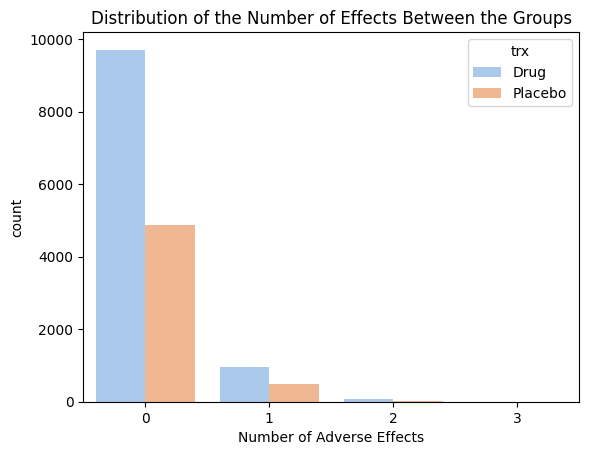

In [120]:
plot_num_eff = sns.countplot(x="num_effects", data=drug_safety, hue='trx')

plt.xlabel("Number of Adverse Effects")
plt.title("Distribution of the Number of Effects Between the Groups")



Considering that the ratio of drug observations to placebo observations is 2 to 1,the distribution of the number of adverse affects between two groups is aproximately the same with the majority of patients having no adverse affects at all.

## Hypothesis testing

Know we will check our hypothesis and conduct a two-sample Z-test to determine if the proportion of adverse effects differs between the Drug and Placebo groups.

H0: Proportion of adverse effects is the same between the Drug and Placebo groups.

Ha: Proportion of adverse effects  differs significantly between the Drug and Placebo groups.

In [121]:
# Count the adverse_effects column values for each trx group
adv_eff_by_trx = drug_safety.groupby("trx")['adverse_effects'].value_counts()

# Compute total rows in each group
adv_eff_by_trx_totals = adv_eff_by_trx.groupby("trx").sum()

# Create an array of the "Yes" counts for each group
yeses = [adv_eff_by_trx["Drug"]["Yes"], adv_eff_by_trx["Placebo"]["Yes"]]

# Create an array of the total number of rows in each group
n = [adv_eff_by_trx_totals["Drug"], adv_eff_by_trx_totals["Placebo"]]

# Perform a two-sided z-test on the two proportions
two_samp_z_stat, two_samp_z_p_value = proportions_ztest(yeses, n)
two_samp_z_stat = np.round(two_samp_z_stat, 3)
two_samp_z_p_value = np.round(two_samp_z_p_value, 3)

We fail to reject the null hypothesis since the p-value is significantly higher than alpha=0.05 suggesting that the proportion of adverse_effects doesn't differ between the trx groups meaning the pharmaceutical drug doesn't create statistically significant side effects. The variables should be considered statistically independent.

### Association between adverse effects and the groups

Next we test if num_effects and trx are independent to determine whether trx influences the number of effects by performing a Chi-square test of independence.

Ho: The variables num_effects and trx are independent.

Ha: There is dependancy between variables num_effects and trx.

In [122]:
expected, observed, stats = pingouin.chi2_independence(data=drug_safety, x='trx', y='num_effects', correction=False)
pearson_num_effect_trx = stats[stats['test'] == 'pearson'].round(3)
pearson_num_effect_trx

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,1.8,3.0,0.615,0.011,0.176


We fail to reject the null hypothesis as the p-value is significantly higher than alpha=0.05, suggesting there is no association between the number of adverse effects and the groups.

### Distribution of age in the Drug and Placebo groups
Next, we want to explore the distribution of age in both groups.


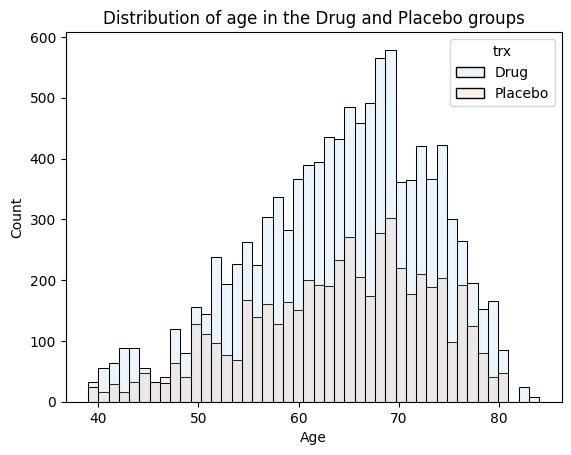

In [123]:
sns.histplot(data=drug_safety,x='age', hue='trx',alpha=0.2)
plt.title('Distribution of age in the Drug and Placebo groups')
plt.xlabel('Age')
plt.show()

The age distribution of both groups strongly suggests a non-parametric independent samples test. 
To ensure age wasn't a confounder, we will conduct a Mann-Whitney U test to determine if age differs significantly between the trx groups. 

Ho: There is no significant difference between the ages of the Drug and Placebo groups.

Ha: There is a significant difference between the ages of the Drug and Placebo groups.

In [124]:
drug_group = drug_safety.loc[drug_safety['trx'] == 'Drug', 'age']
placebo_group = drug_safety.loc[drug_safety['trx'] == 'Placebo', 'age']
two_ind_samp_results=pingouin.mwu(drug_group,placebo_group,alternative='two-sided').round(3)
two_ind_samp_results

,U-val,alternative,p-val,RBC,CLES
MWU,29149339.5,two-sided,0.257,-0.011,0.505


We fail to reject the null hypothesis as p-value is higher than the signifiance level 0.05. It suggests that there is no significant difference between the ages of the Drug and Placebo groups.